# 4. Preprocessing & Modeling

After exploring our dataset, we now proceed to the preprocessing and modeling process of the project. 

<b>Models to be used</b>

We will be training the following models:

1. Linear Regression
2. Lasso Regression
3. Ridge Regression
4. Random Forest Regresson
5. XG Boost Regression
6. Feed Forward Neural Network
7. Neural Network with Weight Decay
8. Neural Network with Dropout Method

<b>Rationale on using these models</b>

- Linear, Lasso and Ridge are more like base models and would very quickly give me an idea on the RMSE score range for this project 
- I would expect Random Forest and XG Boost to do much better than the 3 linear regression models given that they are more advanced supervised learning models
- Lastly, I would like to test out the neural network's ability to accurately predict the resale prices as well. However we note that these networks are very 'black box' and can be very hard to interpret its result. Additionally, in order to achieve high performance, these networks usually require extremely large datasets (ideally in the millions). Therefore, it may be a too excessive model to use for this project but let's try it out anyways

<b>Considerations when building the models</b>
- The time taken to run these models, considering that our dataset is relatively large with over 200,000 rows and almost 180 columns 

<b>Model tuning (specificially for Random Forest and XG Boost)</b>
- I am thinking to set a couple of hyperparameters as a first run of tuning. This will like take a few hours to gridsearch, but we would be able to quickly remove hyperparameter values which are not ideal. For subsequent runs, we can test out a smaller set of values and slowly tune the model 

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle

from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

In [2]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# Functions

In [3]:
def append_result(result, train_score, train_rmse, test_score, test_rmse, time, model):
    tmp = pd.DataFrame({
        'model': model,
        'train_r2_score': train_score,
        'train_rmse': round(train_rmse, 2),
        'test_r2_score': test_score,
        'test_rmse': round(test_rmse, 2), 
        'fit_time (min)': round(time, 2)
    },index=[0])
    
    result = pd.concat([result, tmp], axis=0, ignore_index=True)
    return result

# Reading data and preprocessing

In [4]:
df = pd.read_csv('../datasets/final/hdb_combine (3 Nov).csv')

In [5]:
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,longitude,latitude,year_transacted,age,resale_price_inflate,psf,floor_area_sqf,nearest_mrt_station_dist,nearest_mrt_station,nearest_primary_school_dist,nearest_primary_school,nearest_secondary_school_dist,nearest_secondary_school,nearest_mall_dist,nearest_mall,dist_cbd,avg_storey
0,10/1/2011,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,01 TO 03,60.0,Improved,1986,283000.0,103.837619,1.375097,2011,35,311671.5192,438.193096,645.8340,0.420801,MAYFLOWER,0.232987,MAYFLOWER PRIMARY SCHOOL JAN 2019 - DEC 2021,0.595743,YIO CHU KANG SECONDARY SCHOOL,0.990781,BROADWAY PLAZA,10.256373,2
1,10/1/2011,SENGKANG,4 ROOM,259B,COMPASSVALE RD,07 TO 09,85.0,Model A2,2001,461000.0,103.897506,1.393871,2011,20,507705.1956,503.862857,914.9315,0.330347,SENGKANG,0.072371,COMPASSVALE PRIMARY SCHOOL,0.362637,COMPASSVALE SECONDARY SCHOOL,0.337984,COMPASS ONE,13.256963,8
2,10/1/2011,SENGKANG,4 ROOM,249,COMPASSVALE RD,10 TO 12,85.0,Model A2,2000,435000.0,103.899173,1.391762,2011,21,479071.0631,475.445430,914.9315,0.410204,SENGKANG,0.260362,SENG KANG PRIMARY SCHOOL,0.492838,COMPASSVALE SECONDARY SCHOOL,0.457340,COMPASS ONE,13.114723,11
3,10/1/2011,SENGKANG,4 ROOM,247,COMPASSVALE RD,07 TO 09,85.0,Model A2,2000,426000.0,103.899249,1.392092,2011,21,469159.2480,465.608628,914.9315,0.420938,SENGKANG,0.294318,SENG KANG PRIMARY SCHOOL,0.455200,COMPASSVALE SECONDARY SCHOOL,0.464680,COMPASS ONE,13.151793,8
4,10/1/2011,SENGKANG,4 ROOM,322A,ANCHORVALE DR,01 TO 03,85.0,Model A2,2002,430000.0,103.892314,1.391521,2011,19,473564.4992,469.980540,914.9315,0.353131,SENGKANG,0.147520,NAN CHIAU PRIMARY SCHOOL,0.867638,SENG KANG SECONDARY SCHOOL,0.312209,COMPASS ONE,12.800147,2


<b>Accounting for fixed effects and inflation throughout the time period</b>

As my initial dataset was originally a time series data, my initial approach was to account for the time value of HDB prices by adjusting for inflation (as done in part 2 of my notebook under feature engineering). The assumption is that with inflation adjusted prices, we could then drop the time related data ('month' column) and train our models on the data directly. 

However, I learnt something new from my classmate (Ethan) today who is working on a time series project. He shared how we could add in [fixed effects](https://are.berkeley.edu/courses/EEP118/current/handouts/eep118_panel_data_fixed_effects.pdf) to account for unforeseen time based macro factors which influenced HDB prices (for example: unexpected cooling measures in 2013, Covid in 2020). We can do this by dummifying the time (month) column using OneHotEncoder.

We could also feature engineer an additional column based off the 'month' column, by assigning an abitrary value to each year to account for inflationary effects. In this case, 2011 transactions would be assigned a value of 1 while 2021 transactions would be assigned a value of 11. In this case, our target column would be the resale price at nominal value (unadjusted for inflation).

Upon running this revised dataset through the models, I compared the model results against the model results from the previous dataset using inflation adjusted resale prices. The results were clear: across the board, we generally a reduction of RMSE of between 6,000 to 10,000.

Note that to consolidate the notebook better and not make it too lengthy, I did not include the results of the models using the previous dataset(with inflation adjusted prices as our target column).

In [6]:
# creating a new dummy year column by creating a range of values beginning from 1 for entire time period
df['year_index'] = df['year_transacted'] - 2010

## Dummify categorical columns: town, flat_type, flat_model with OneHotEncoder

In [7]:
enc = OneHotEncoder(drop='first')

In [8]:
# creating dummy variables for town, flat_type, flat_model and month columns
enc_df = pd.DataFrame(enc.fit_transform(
                    df[['town', 'flat_type', 'flat_model', 'month']]).toarray(),
                    columns=enc.get_feature_names(['town', 'flat_type', 'flat_model', 'month']))

After One Hot Encoding, we proceed to drop the original 3 columns: town, flat_type, flat_model

In [9]:
df.drop(columns=['town', 'flat_type', 'flat_model', 'month'], inplace=True)

In [10]:
df = df.join(enc_df)

We will not use the columns: block, street_name, storey_range, floor_area_sqm, lease_commence_date, resale_price_inflate, longitude and latitude data since these columns were used to feature engineer other more relevant features. In this case, we will drop them.

Additionally, we will drop psf as well since it is correlated to the resale price which is our target column.

In [11]:
feature_drop = ['block', 'street_name', 'storey_range', 'floor_area_sqm', 'lease_commence_date',  'resale_price_inflate', 
                'longitude', 'latitude','psf']

In [12]:
df.drop(columns=feature_drop, inplace=True)

We will also drop columns such nearest mrt, primary school, secondary school and malls which were more relevant during the EDA process. We will also drop 'year_transacted' column as our 'resale_price_inflate' column already takes that into account.

In [13]:
df.drop(columns=['nearest_mrt_station', 'nearest_primary_school', 'nearest_secondary_school', 'nearest_mall', 'year_transacted'], inplace=True)

In [14]:
df.head()

,resale_price,age,floor_area_sqf,nearest_mrt_station_dist,nearest_primary_school_dist,nearest_secondary_school_dist,nearest_mall_dist,dist_cbd,avg_storey,year_index,town_BEDOK,town_BISHAN,town_BUKIT BATOK,town_BUKIT MERAH,town_BUKIT PANJANG,town_BUKIT TIMAH,town_CENTRAL AREA,town_CHOA CHU KANG,town_CLEMENTI,town_GEYLANG,town_HOUGANG,town_JURONG EAST,town_JURONG WEST,town_KALLANG/WHAMPOA,town_MARINE PARADE,town_PASIR RIS,town_PUNGGOL,town_QUEENSTOWN,town_SEMBAWANG,town_SENGKANG,town_SERANGOON,town_TAMPINES,town_TOA PAYOH,town_WOODLANDS,town_YISHUN,flat_type_2 ROOM,flat_type_3 ROOM,flat_type_4 ROOM,flat_type_5 ROOM,flat_type_EXECUTIVE,flat_type_MULTI-GENERATION,flat_model_Adjoined flat,flat_model_Apartment,flat_model_DBSS,flat_model_Improved,flat_model_Improved-Maisonette,flat_model_Maisonette,flat_model_Model A,flat_model_Model A-Maisonette,flat_model_Model A2,...,month_5/1/2012,month_5/1/2013,month_5/1/2014,month_5/1/2015,month_5/1/2016,month_5/1/2017,month_5/1/2018,month_5/1/2019,month_5/1/2020,month_5/1/2021,month_6/1/2012,month_6/1/2013,month_6/1/2014,month_6/1/2015,month_6/1/2016,month_6/1/2017,month_6/1/2018,month_6/1/2019,month_6/1/2020,month_6/1/2021,month_7/1/2012,month_7/1/2013,month_7/1/2014,month_7/1/2015,month_7/1/2016,month_7/1/2017,month_7/1/2018,month_7/1/2019,month_7/1/2020,month_7/1/2021,month_8/1/2012,month_8/1/2013,month_8/1/2014,month_8/1/2015,month_8/1/2016,month_8/1/2017,month_8/1/2018,month_8/1/2019,month_8/1/2020,month_8/1/2021,month_9/1/2012,month_9/1/2013,month_9/1/2014,month_9/1/2015,month_9/1/2016,month_9/1/2017,month_9/1/2018,month_9/1/2019,month_9/1/2020,month_9/1/2021
0,283000.0,35,645.8340,0.420801,0.232987,0.595743,0.990781,10.256373,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,461000.0,20,914.9315,0.330347,0.072371,0.362637,0.337984,13.256963,8,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,435000.0,21,914.9315,0.410204,0.260362,0.492838,0.457340,13.114723,11,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,426000.0,21,914.9315,0.420938,0.294318,0.455200,0.464680,13.151793,8,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,430000.0,19,914.9315,0.353131,0.147520,0.867638,0.312209,12.800147,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Baseline model

Our baseline model will use the mean of resale prices in the train set as the predictor of sale prices in the test set.

In [15]:
X = df[['floor_area_sqf']]
y = df['resale_price']  

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)

In [17]:
# Baseline predictor 
y_pred = round(y_train.mean(), 2)
y_pred

453112.32

In [18]:
print(f'The RMSE score on the train set {round(np.sqrt(mean_squared_error(y_train, [y_pred] * len(y_train))), 2)}')

The RMSE score on the train set 144231.76


In [19]:
print(f'The RMSE score on the test set {round(np.sqrt(mean_squared_error(y_test, [y_pred] * len(y_test))), 2)}')

The RMSE score on the test set 142974.59


# Linear Regression model with 1 feature

We will set the baseline model as only having 1 feature which is the sqf area of the HDB apartments.

In [20]:
X = df[['floor_area_sqf']]
y = df['resale_price']  

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)

In [22]:
# Instantiate the model
lr = LinearRegression()

In [23]:
start = time.time()

# Fit the data to the model
lr.fit(X_train, y_train)

end = time.time()

In [24]:
cross_val_score(lr, X_train, y_train, cv=5).mean()

0.4246939198100894

In [25]:
# train r2 score
train_score = lr.score(X_train, y_train)
# test r2 score
test_score = lr.score(X_test, y_test)
# RMSE on train set
train_rmse = np.sqrt(mean_squared_error(y_train, lr.predict(X_train)))
# RMSE on test set
test_rmse = np.sqrt(mean_squared_error(y_test, lr.predict(X_test)))
# time taken to fit model
fit_time = (end - start) / 60

In [26]:
results_df = pd.DataFrame(columns=[
    'model',
    'train_r2_score',
    'train_rmse',
    'test_r2_score',
    'test_rmse',
    'fit_time (min)'
])

In [27]:
results_df = append_result(results_df, train_score, train_rmse, test_score, test_rmse, fit_time, 
                           'Linear Regression (1 feature)')

In [28]:
results_df

,model,train_r2_score,train_rmse,test_r2_score,test_rmse,fit_time (min)
0,Linear Regression (1 feature),0.424661,109401.4,0.431538,107794.18,0.0


# Scale data

In [29]:
# define X and y
X = df.drop(columns='resale_price')                
y = df['resale_price']                            

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)

In [31]:
# using ColumnTransformer to standardscale only the continuous columns and not dummy columns

ct = ColumnTransformer([
    ('transform', StandardScaler(), ['age',
       'nearest_mrt_station_dist', 'nearest_primary_school_dist',
       'nearest_secondary_school_dist', 'nearest_mall_dist', 'dist_cbd',
       'avg_storey', 'floor_area_sqf'])
], remainder='passthrough')

In [32]:
X_train_sc = ct.fit_transform(X_train)
X_test_sc = ct.transform(X_test)

In [33]:
# to save X_train, X_test, y_train, y_test to run neural network models in another notebook

X_train.to_csv('../datasets/final/X_train.csv', index=False)
X_test.to_csv('../datasets/final/X_test.csv', index=False)
y_train.to_csv('../datasets/final/y_train.csv', index=False)
y_test.to_csv('../datasets/final/y_test.csv', index=False)

# Linear Regression model with all features

In [34]:
# Instantiate the model
lr = LinearRegression()

In [35]:
start = time.time()

# Fit the data to the model
lr.fit(X_train_sc, y_train)

end = time.time()

In [36]:
cross_val_score(lr, X_train_sc, y_train, cv=5).mean()

0.8863830630321077

In [37]:
# train r2 score
train_score = lr.score(X_train_sc, y_train)
# test r2 score
test_score = lr.score(X_test_sc, y_test)
# RMSE on train set
train_rmse = np.sqrt(mean_squared_error(y_train, lr.predict(X_train_sc)))
# RMSE on test set
test_rmse = np.sqrt(mean_squared_error(y_test, lr.predict(X_test_sc)))
# time taken to fit model
fit_time = (end - start) / 60

In [38]:
results_df = append_result(results_df, train_score, train_rmse, test_score, test_rmse, fit_time, 
                           'Linear Regression (all features)')
results_df

,model,train_r2_score,train_rmse,test_r2_score,test_rmse,fit_time (min)
0,Linear Regression (1 feature),0.424661,109401.40,0.431538,107794.18,0.00
1,Linear Regression (all features),0.886708,48546.76,0.885599,48357.07,0.02


# Lasso Regression

In [39]:
# Instantiate LassoCV to find optimal alpha
lasso_cv = LassoCV(n_alphas=500, cv=5, max_iter=50000)

In [40]:
# Fit the training data to the model and find the time taken
start = time.time()
lasso_cv.fit(X_train_sc, y_train)
end = time.time()

In [41]:
print(f'The optimal alpha is {lasso_cv.alpha_}')

The optimal alpha is 93.99008619958953


This will be our optimal alpha (hyperparamter) which we will put into Lasso model. This optimal alpha penalizes coefficients of features which are too far from zero. As a result, these coefficients are reduced to zeros under Lasso, which is also a form of feature selection. 

The higher the value of alpha, more regularization would have taken place, meaning more features are set to zero and eliminated.

In [42]:
# instantiate lasso with optimal alpha
lasso = Lasso(alpha=lasso_cv.alpha_)

lasso.fit(X_train_sc, y_train)

Lasso(alpha=93.99008619958953)

In [43]:
train_score = lasso.score(X_train_sc, y_train)
test_score = lasso.score(X_test_sc, y_test)
train_rmse = np.sqrt(mean_squared_error(y_train, lasso.predict(X_train_sc)))
test_rmse = np.sqrt(mean_squared_error(y_test, lasso.predict(X_test_sc)))
fit_time = (end - start) / 60

In [44]:
results_df = append_result(results_df, train_score, train_rmse, test_score, test_rmse, fit_time,
                           'Lasso Regression (all features)')
results_df

,model,train_r2_score,train_rmse,test_r2_score,test_rmse,fit_time (min)
0,Linear Regression (1 feature),0.424661,109401.40,0.431538,107794.18,0.00
1,Linear Regression (all features),0.886708,48546.76,0.885599,48357.07,0.02
2,Lasso Regression (all features),0.879362,50096.00,0.878561,49822.21,0.46


We will look at the lasso coefficients to see which features had the most impact in predicting resale price.

In [45]:
df_lasso = pd.DataFrame({'features':X_train.columns,
                         'coeff':lasso.coef_,
                         'absolute_coeff':np.abs(lasso.coef_)})

We will also create another column for absolutes of the coefficients to account for highly negative correlation, if any.

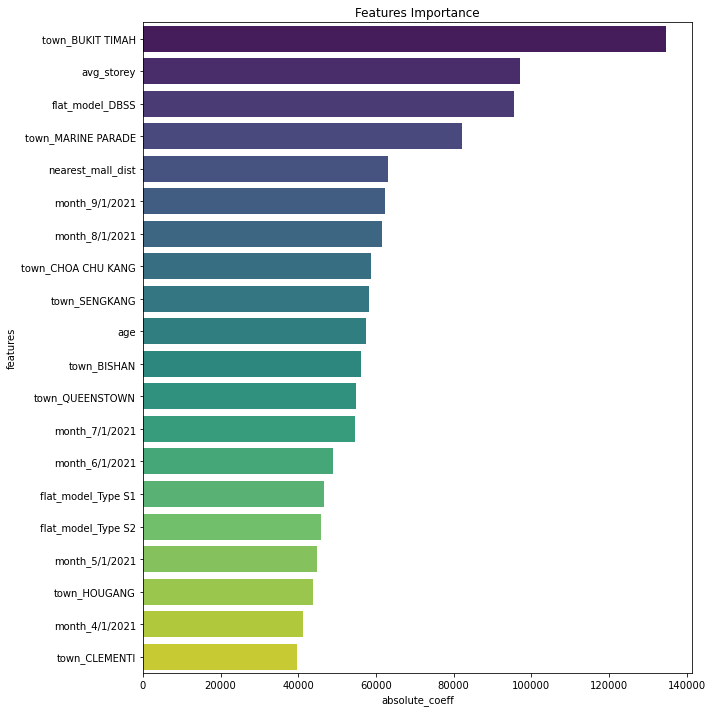

In [46]:
df_lasso_top20 = df_lasso.sort_values(by='absolute_coeff', ascending=False).head(20)

fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(data=df_lasso_top20, y='features', x='absolute_coeff', palette='viridis')

plt.title('Features Importance')
plt.tight_layout()
plt.show()

We also note that there were features zeroed-out by Lasso. In this case, this is a form of feature selection as well. We will have look at features which were zero-out.

In [47]:
df_lasso.loc[df_lasso['coeff'] == 0, :]

,features,coeff,absolute_coeff
9,town_BEDOK,-0.0,0.0
15,town_CENTRAL AREA,-0.0,0.0
24,town_PASIR RIS,-0.0,0.0
36,flat_type_4 ROOM,-0.0,0.0
39,flat_type_MULTI-GENERATION,0.0,0.0
40,flat_model_Adjoined flat,0.0,0.0
41,flat_model_Apartment,0.0,0.0
44,flat_model_Improved-Maisonette,0.0,0.0
49,flat_model_Multi Generation,0.0,0.0
52,flat_model_Premium Apartment Loft,0.0,0.0


# Ridge Regression

In [48]:
# instantiate RidgeCV to find optimal alpha
ridge_cv = RidgeCV(alphas = np.logspace(0, 5, 100),
                   cv = 5)

In [49]:
# fit the model
start = time.time()
ridge_cv.fit(X_train_sc, y_train)
end = time.time()

In [50]:
print(f'The optimal alpha is {ridge_cv.alpha_}')

The optimal alpha is 1.0


This will be our optimal alpha which we will put into Lasso model. This optimal alpha penalizes coefficients of features which are too far from zero, thus enforcing them to small. As a result, these coefficients are reduced to almost zero. This reduces the model complexity while keeping all the variables in the model.

In [51]:
# instantiate ridge with optimal alpha
ridge = Ridge(alpha=ridge_cv.alpha_)

In [52]:
# fit model
ridge.fit(X_train_sc, y_train)

Ridge()

In [53]:
train_score = ridge.score(X_train_sc, y_train)
test_score = ridge.score(X_test_sc, y_test)
train_rmse = np.sqrt(mean_squared_error(y_train, ridge.predict(X_train_sc)))
test_rmse = np.sqrt(mean_squared_error(y_test, ridge.predict(X_test_sc)))
fit_time = (end - start) / 60

In [54]:
results_df = append_result(results_df, train_score, train_rmse, test_score, test_rmse, fit_time, 
                           'Ridge Regression (all features)')
results_df

,model,train_r2_score,train_rmse,test_r2_score,test_rmse,fit_time (min)
0,Linear Regression (1 feature),0.424661,109401.40,0.431538,107794.18,0.00
1,Linear Regression (all features),0.886708,48546.76,0.885599,48357.07,0.02
2,Lasso Regression (all features),0.879362,50096.00,0.878561,49822.21,0.46
3,Ridge Regression (all features),0.886702,48547.97,0.885582,48360.57,3.68


We will look at the ridge coefficients to see which features had the most impact in predicting resale price.

In [55]:
df_ridge = pd.DataFrame({'features':X_train.columns,
                         'coeff':ridge.coef_,
                         'absolute_coeff':np.abs(ridge.coef_)})

We will also create another column for absolutes of the coefficients to account for highly negative correlation, if any.

In [56]:
df_ridge.sort_values(by='absolute_coeff', ascending=False).head(20)

,features,coeff,absolute_coeff
57,flat_model_Type S2,181930.272253,181930.272253
14,town_BUKIT TIMAH,167645.158470,167645.158470
56,flat_model_Type S1,127636.428677,127636.428677
44,flat_model_Improved-Maisonette,101877.943492,101877.943492
23,town_MARINE PARADE,95070.637223,95070.637223
16,town_CHOA CHU KANG,-89358.683938,89358.683938
7,avg_storey,79660.663914,79660.663914
28,town_SENGKANG,-78220.160885,78220.160885
27,town_SEMBAWANG,-77784.830505,77784.830505
52,flat_model_Premium Apartment Loft,71750.242930,71750.242930


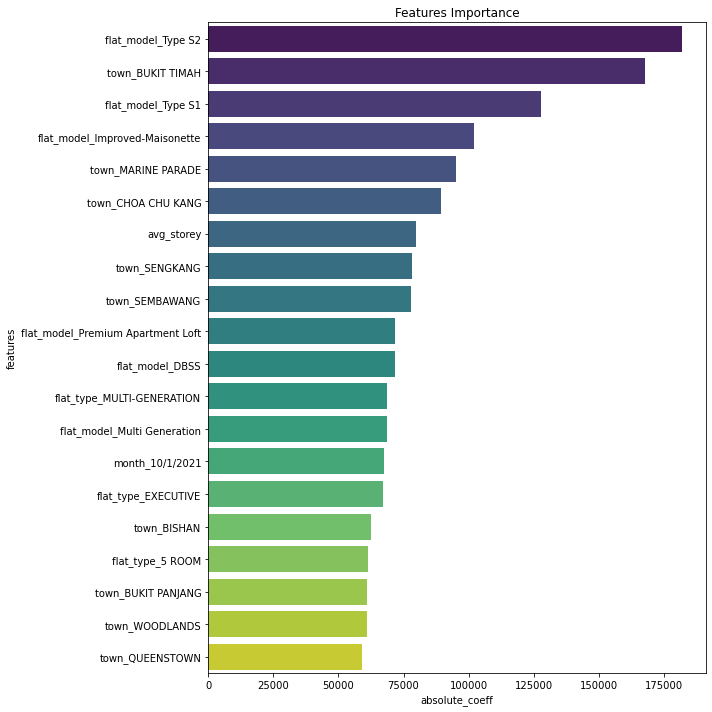

In [57]:
df_ridge_top20 = df_ridge.sort_values(by='absolute_coeff', ascending=False).head(20)

fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(data=df_ridge_top20, y='features', x='absolute_coeff', palette='viridis')

plt.title('Features Importance')
plt.tight_layout()
plt.show()

# Random Forest Regression

Random Forest is a bagging (bootstrapped aggregation) technique that contains a number of decision trees on various subsets of the given dataset and takes the average to improve the predictive accuracy of the dataset. Instead of relying on 1 decision tree, the random forest takes the prediction from each tree and based on majority votes of the predictions, it predicts the final output. The greater the number of trees, the higher the accuracy and prevents the problem of overfitting.

Random Forest has two random elements:
1. random subset of features
2. Bootstrap samples of data

In [58]:
# instantiate model
rf = RandomForestRegressor(random_state=100)

In [59]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 100,
 'verbose': 0,
 'warm_start': False}

In [60]:
# cross validate with default model parameters
np.sqrt(-cross_val_score(rf, 
                         X_train_sc, y_train, scoring='neg_mean_squared_error')).mean()

25055.95757850125

In [61]:
rf_params = {
    'n_estimators': [300],                     # 100, 150, 200, 250, 300, 350
    'max_depth': [25],                         # 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40 
    'min_samples_split': [7],                  # 1, 2, 3, 4, 5, 7
    'min_samples_leaf': [3],                   # 1, 2, 3, 5
    'max_features': [0.7]                      # auto, 0.3, 0.5, 0.7, 0.8, sqrt, log2
}

In [62]:
gs_rf = GridSearchCV(rf, rf_params, verbose=1, n_jobs=-1, scoring='neg_mean_squared_error')

In [63]:
# fit gridsearch model
start = time.time()
gs_rf.fit(X_train_sc, y_train)
end = time.time()

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [64]:
# RMSE score
np.sqrt(-gs_rf.best_score_)

24787.691513169797

In [65]:
(end - start)/60

31.30007813771566

In [66]:
# 7th Nov

# RMSE GS
# 24787 - 120 mins for 40 fits

#{'max_depth': 25,           vs 20
# 'max_features': 0.7,       vs 0.8
# 'min_samples_leaf': 3,     
# 'min_samples_split': 7,    
# 'n_estimators': 300}       vs 250


# RMSE GS
# 25255 - 58 mins for 20 fits

#{'max_depth': 20,           vs 15
# 'max_features': 0.7,       
# 'min_samples_leaf': 3,     
# 'min_samples_split': 7,    
# 'n_estimators': 300}       vs 250

# RMSE GS
# 28308 - 130 mins for 80 fits

#{'max_depth': 15,           vs 10
# 'max_features': 0.7,       vs 0.5
# 'min_samples_leaf': 3,     
# 'min_samples_split': 7,    vs 9
# 'n_estimators': 250}       vs 200


# RMSE GS
# 39961 - 249 mins for 160 fits

#{'max_depth': 10,           
# 'max_features': 0.5,       vs auto, 0.3
# 'min_samples_leaf': 3,     vs 5
# 'min_samples_split': 7,    vs 3, 5, 7
# 'n_estimators': 200}       vs 250

# 6th Nov

# RMSE GS
# 40209 - 170 mins

#{'max_depth': 10,
# 'max_features': 'auto',
# 'min_samples_leaf': 3,
# 'min_samples_split': 2,
# 'n_estimators': 200}

# 5th Nov

# RMSE GS
# 44016

#{'max_depth': 9,
# 'max_features': 'auto',
# 'min_samples_leaf': 1,
# 'min_samples_split': 3,
# 'n_estimators': 150}

# RMSE GS
# 48244

#{'max_depth': 8,
# 'max_features': 'auto',
# 'min_samples_leaf': 1,
# 'min_samples_split': 3,
# 'n_estimators': 100}

# RMSE GS
# 59775

#{'max_depth': 6,
# 'max_features': 'auto',
# 'min_samples_leaf': 1,
# 'min_samples_split': 2,
# 'n_estimators': 100}

# RMSE GS
# 66202

#{'max_depth': 5,
# 'max_features': 'auto',
# 'min_samples_leaf': 1,
# 'min_samples_split': 2,
# 'n_estimators': 150}

# RMSE GS
# 74540

#{'max_depth': 4,
# 'min_samples_leaf': 1,
# 'min_samples_split': 2,
# 'n_estimators': 200}

# 4th Nov
# RMSE GS
# 24969

#{'max_depth': 35,
# 'min_samples_leaf': 1,
# 'min_samples_split': 2,
# 'n_estimators': 300}

In [67]:
gs_rf.best_params_

{'max_depth': 25,
 'max_features': 0.7,
 'min_samples_leaf': 3,
 'min_samples_split': 7,
 'n_estimators': 300}

## Use model with best params

In [68]:
rf = RandomForestRegressor(max_depth=25, max_features=0.7, min_samples_leaf=3, min_samples_split=7, n_estimators=300, random_state=100)

In [69]:
rf.fit(X_train_sc, y_train)

RandomForestRegressor(max_depth=25, max_features=0.7, min_samples_leaf=3,
                      min_samples_split=7, n_estimators=300, random_state=100)

In [70]:
train_score = rf.score(X_train_sc, y_train)
test_score = rf.score(X_test_sc, y_test)
train_rmse = np.sqrt(mean_squared_error(y_train, rf.predict(X_train_sc)))
test_rmse = np.sqrt(mean_squared_error(y_test, rf.predict(X_test_sc)))
fit_time = (end - start) / 60

In [71]:
results_df = append_result(results_df, train_score, train_rmse, test_score, test_rmse, fit_time,
                           'Random Forest Regression (all features)')
results_df

,model,train_r2_score,train_rmse,test_r2_score,test_rmse,fit_time (min)
0,Linear Regression (1 feature),0.424661,109401.40,0.431538,107794.18,0.00
1,Linear Regression (all features),0.886708,48546.76,0.885599,48357.07,0.02
2,Lasso Regression (all features),0.879362,50096.00,0.878561,49822.21,0.46
3,Ridge Regression (all features),0.886702,48547.97,0.885582,48360.57,3.68
4,Random Forest Regression (all features),0.986806,16567.43,0.972037,23907.57,31.30


## Feature importance

In [72]:
rf_feature_df = pd.DataFrame({'feature_name': X_train.columns,
                              'feature_importance': rf.feature_importances_})

In [73]:
rf_feature_df.sort_values(by='feature_importance', ascending=False).head(20)

,feature_name,feature_importance
7,avg_storey,0.365709
5,nearest_mall_dist,0.246626
0,age,0.082611
35,flat_type_3 ROOM,0.058428
36,flat_type_4 ROOM,0.036272
6,dist_cbd,0.032483
8,year_index,0.029450
1,floor_area_sqf,0.029082
38,flat_type_EXECUTIVE,0.025484
4,nearest_secondary_school_dist,0.014837


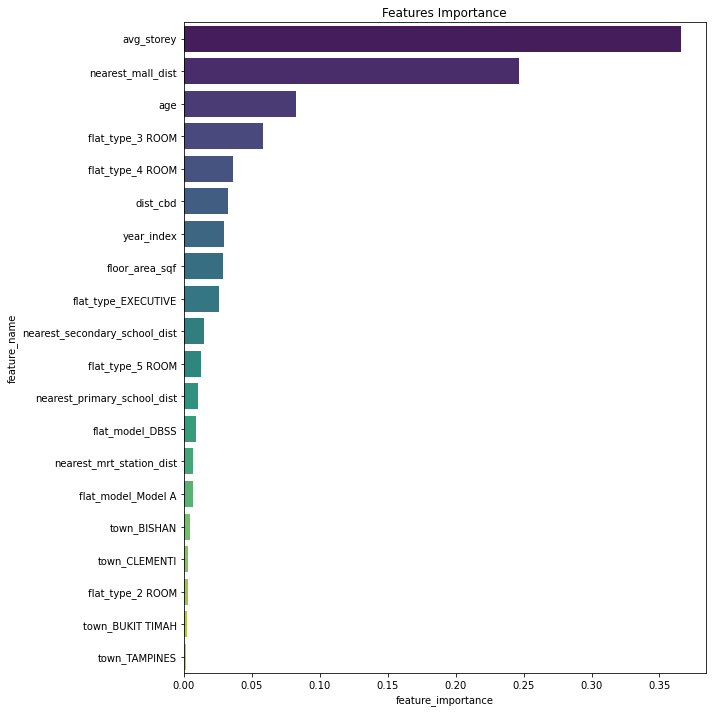

In [74]:
rf_top20 = rf_feature_df.sort_values(by='feature_importance', ascending=False).head(20)

fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(data=rf_top20, y='feature_name', x='feature_importance', palette='viridis')

plt.title('Features Importance')
plt.tight_layout()
plt.show()

By sorting the values from the largest to lowest, the table above shows the top 20 feature importance in predicting a HDB's resale price.

Feature importances for the Random Forest are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree (pulled from sklearn documentation). 

# ExtraTrees Regression

In [75]:
# instantiate model
et = ExtraTreesRegressor(random_state=100)

In [76]:
et.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 100,
 'verbose': 0,
 'warm_start': False}

In [77]:
# cross validate with default model parameters
np.sqrt(-cross_val_score(et, 
                         X_train_sc, y_train, scoring='neg_mean_squared_error')).mean()

24616.044508790663

In [78]:
et_params = {
    'max_depth': [12],                        # 3, 5, 7, 8, 10, 12
    'max_features': ['auto'],                 # auto, 0.3, 0.5, try sqrt and log2 if possible
    'min_samples_leaf': [3],                  # 1, 3, 5
    'min_samples_split': [4],                 # 2, 4, 6
    'n_estimators': [200]                     # 150, 200, 250  
}

In [79]:
gs_et = GridSearchCV(et, et_params, verbose=1, n_jobs=-1, scoring='neg_mean_squared_error')

In [80]:
# fit gridsearch model
start = time.time()
gs_et.fit(X_train_sc, y_train)
end = time.time()

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [81]:
(end - start)/60

31.995742019017538

In [82]:
# RMSE score
np.sqrt(-gs_et.best_score_)

37422.60397400021

In [83]:
gs_et.best_params_

{'max_depth': 12,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 4,
 'n_estimators': 200}

In [84]:
# 7th Nov

# 37423 for 120 fits 393 mins

#{'max_depth': 12,           vs 8, 10
# 'max_features': 'auto',   
# 'min_samples_leaf': 3,    vs 5
# 'min_samples_split': 4,   vs 6
# 'n_estimators': 200}      vs 250

# 56645 for 360 fits 130 mins

#{'max_depth': 7,           vs 3, 5
# 'max_features': 'auto',   vs 0.3, 0.5
# 'min_samples_leaf': 3,    vs 1
# 'min_samples_split': 2,   vs 4
# 'n_estimators': 200}      vs 150

## Use model with best params

In [85]:
et = ExtraTreesRegressor(max_depth=12, max_features='auto', min_samples_leaf=3, 
                         min_samples_split=4, n_estimators=200, random_state=100)

In [86]:
et.fit(X_train_sc, y_train)

ExtraTreesRegressor(max_depth=12, min_samples_leaf=3, min_samples_split=4,
                    n_estimators=200, random_state=100)

In [87]:
train_score = et.score(X_train_sc, y_train)
test_score = et.score(X_test_sc, y_test)
train_rmse = np.sqrt(mean_squared_error(y_train, et.predict(X_train_sc)))
test_rmse = np.sqrt(mean_squared_error(y_test, et.predict(X_test_sc)))
fit_time = (end - start) / 60

In [88]:
results_df = append_result(results_df, train_score, train_rmse, test_score, test_rmse, fit_time,
                           'ExtraTrees Regression (all features)')
results_df

,model,train_r2_score,train_rmse,test_r2_score,test_rmse,fit_time (min)
0,Linear Regression (1 feature),0.424661,109401.40,0.431538,107794.18,0.00
1,Linear Regression (all features),0.886708,48546.76,0.885599,48357.07,0.02
2,Lasso Regression (all features),0.879362,50096.00,0.878561,49822.21,0.46
3,Ridge Regression (all features),0.886702,48547.97,0.885582,48360.57,3.68
4,Random Forest Regression (all features),0.986806,16567.43,0.972037,23907.57,31.30
5,ExtraTrees Regression (all features),0.935992,36490.27,0.932610,37114.43,32.00


## Feature importance

In [89]:
et_feature_df = pd.DataFrame({'feature_name': X_train.columns,
                              'feature_importance': et.feature_importances_})

In [90]:
et_feature_df.sort_values(by='feature_importance', ascending=False).head(20)

,feature_name,feature_importance
35,flat_type_3 ROOM,0.263484
5,nearest_mall_dist,0.202811
36,flat_type_4 ROOM,0.083929
0,age,0.076528
7,avg_storey,0.068572
38,flat_type_EXECUTIVE,0.043747
34,flat_type_2 ROOM,0.040913
37,flat_type_5 ROOM,0.031427
6,dist_cbd,0.021177
1,floor_area_sqf,0.018981


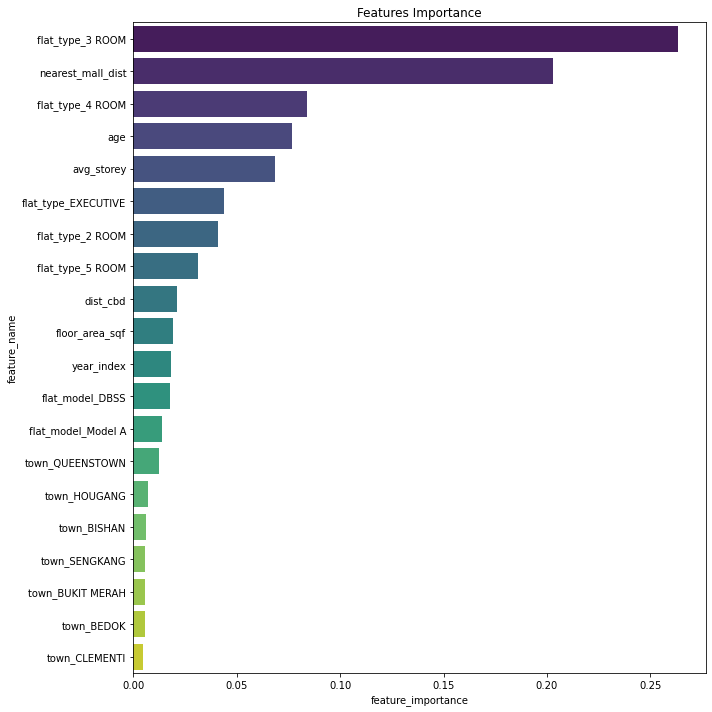

In [91]:
et_top20 = et_feature_df.sort_values(by='feature_importance', ascending=False).head(20)

fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(data=et_top20, y='feature_name', x='feature_importance', palette='viridis')

plt.title('Features Importance')
plt.tight_layout()
plt.show()

By sorting the values from the largest to lowest, the table above shows the top 20 feature importance in predicting a HDB's resale price.


# XG Boost Regression

XG Boost or Extreme Gradient Boosting is a form of iterative learning in which the model will predict something initially and self analyze its mistakesand give more weightage to the data points in which it made a wrong prediction in the next iteration. This process continues as a cycle and it optimizes itself for each iteration.

This is unlike Random Forest or ExtraTrees which is just a collection of trees in which each of them gives a prediction and we collect the outputs from all the trees and considers an aggregation (mean/median/mode) of this collection as the prediction of this forest. At a high level, it seems fine but there is a possibility that some trees could have made predictions with some random chances.

In [92]:
# instantiate model
xg = XGBRegressor(random_state=100)

In [93]:
xg.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'gamma': None,
 'gpu_id': None,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 100,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [94]:
# cross validate with default model parameters
np.sqrt(-cross_val_score(xg, 
                         X_train_sc, y_train, scoring='neg_mean_squared_error')).mean()

27159.68198037688

In [95]:
xg_params = {
    'learning_rate': [0.1],                  # 0.01, 0.03, 0.05, 0.1, 0.2
    'n_estimators': [250],                   # 100, 150, 200, 250, 300, 350, 400
    'max_depth': [9],                        # 5, 10, 15, 20
    'colsample_bytree': [0.5],               # 0.3, 0.5, 0.7
    'subsample': [0.8]                       # 0.6, 0.8, 1
}

[Hyper parameter tuning](https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663):

- learning_rate: The learning rate determines the step size at each iteration while your model optimizes toward its objective. A low learning rate makes computation slower, and requires more rounds to achieve the same reduction in residual error as a model with a high learning rate. But it optimizes the chances to reach the best optimum. Default is 0.3
- max_depth: Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit
- colsample_bytree: the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed

Colsample_bytree and subsample add randomness to make training robust to noise.

In [96]:
gs_xg = GridSearchCV(xg, xg_params, verbose=1, n_jobs=-1, scoring='neg_mean_squared_error')

In [97]:
# fit gridsearch model
start = time.time()
gs_xg.fit(X_train_sc, y_train)
end = time.time()

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [98]:
(end-start)/60

7.743164340655009

In [99]:
# RMSE score
np.sqrt(-gs_xg.best_score_)

23718.770544301733

In [100]:
gs_xg.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 9,
 'n_estimators': 250,
 'subsample': 0.8}

In [101]:
# 7th Nov

# RMSE: 23719 for
# 75 mins, 80 fits

#{'colsample_bytree': 0.5,       vs 0.7
# 'learning_rate': 0.1,         vs 0.2
# 'max_depth': 9,               vs 7
# 'n_estimators': 250           vs 200
# 'subsample': 0.8}             vs 0.6, 1

# 6th Nov

# RMSE: 26071 for 

#{'colsample_bytree': 0.7,       vs 0.3, 0.5
# 'learning_rate': 0.1,         vs 0.03, 0.05
# 'max_depth': 7,               vs 3, 5
# 'n_estimators': 200           vs 100, 150
# 'subsample': 0.8}


# 5th Nov

# RMSE: 22805 for 

#{'colsample_bytree': 0.5,
# 'learning_rate': 0.03,
# 'max_depth': 15,
# 'n_estimators': 300}

# RMSE: 22,733 for 

#{'xg__colsample_bytree': 0.5,
# 'xg__learning_rate': 0.05,
# 'xg__max_depth': 15,
# 'xg__n_estimators': 300}

## Use model with best params

In [102]:
xg = XGBRegressor(colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=250, subsample=0.8, random_state=100)

In [103]:
xg.fit(X_train_sc, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=9,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=250, n_jobs=8, num_parallel_tree=1, random_state=100,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [104]:
train_score = xg.score(X_train_sc, y_train)
test_score = xg.score(X_test_sc, y_test)
train_rmse = np.sqrt(mean_squared_error(y_train, xg.predict(X_train_sc)))
test_rmse = np.sqrt(mean_squared_error(y_test, xg.predict(X_test_sc)))
fit_time = (end - start) / 60

In [105]:
results_df = append_result(results_df, train_score, train_rmse, test_score, test_rmse, fit_time, 
                           'XGBoost Regression (all features)')
results_df

,model,train_r2_score,train_rmse,test_r2_score,test_rmse,fit_time (min)
0,Linear Regression (1 feature),0.424661,109401.40,0.431538,107794.18,0.00
1,Linear Regression (all features),0.886708,48546.76,0.885599,48357.07,0.02
2,Lasso Regression (all features),0.879362,50096.00,0.878561,49822.21,0.46
3,Ridge Regression (all features),0.886702,48547.97,0.885582,48360.57,3.68
4,Random Forest Regression (all features),0.986806,16567.43,0.972037,23907.57,31.30
5,ExtraTrees Regression (all features),0.935992,36490.27,0.932610,37114.43,32.00
6,XGBoost Regression (all features),0.981277,19735.78,0.973344,23342.20,7.74


## Feature importance

In [106]:
xg_feature_df = pd.DataFrame({'feature_name': X_train.columns,
                              'feature_importance': rf.feature_importances_})

In [107]:
xg_top20 = xg_feature_df.sort_values(by='feature_importance', ascending=False).head(20)
xg_top20

,feature_name,feature_importance
7,avg_storey,0.365709
5,nearest_mall_dist,0.246626
0,age,0.082611
35,flat_type_3 ROOM,0.058428
36,flat_type_4 ROOM,0.036272
6,dist_cbd,0.032483
8,year_index,0.029450
1,floor_area_sqf,0.029082
38,flat_type_EXECUTIVE,0.025484
4,nearest_secondary_school_dist,0.014837


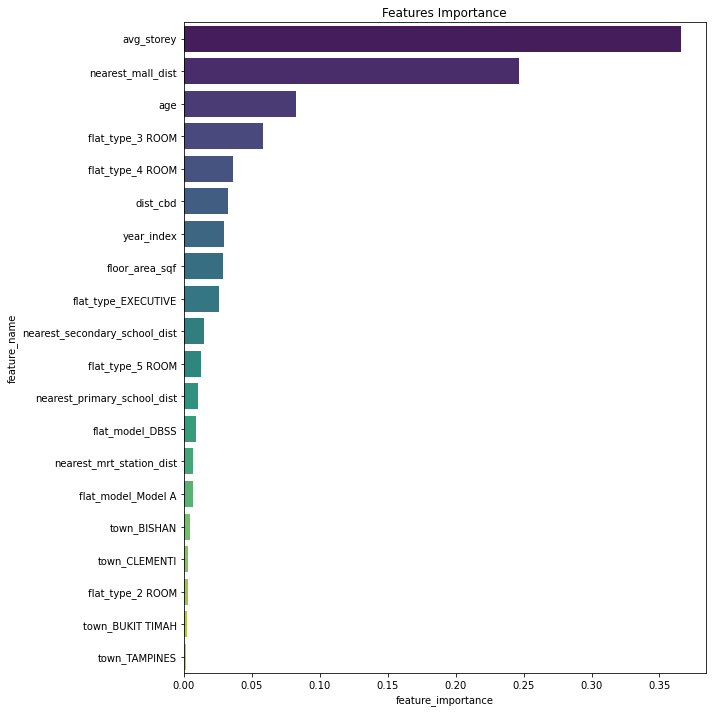

In [108]:
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(data=xg_top20, y='feature_name', x='feature_importance', palette='viridis')

plt.title('Features Importance')
plt.tight_layout()
plt.show()

<b> More elaboration here as XG Boost is our best model </b>

Importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance.

Importance is calculated for a single decision tree by the amount that each attribute split point improves the performance measure, weighted by the number of observations the node is responsible for.

The table above shows the top 20 features/variables which most influenced a HDB's resale price:

1. Overall, we had more physical housing features such as floor level, age, flat type, floor area which were ranked higher in importance compared to distance-based features.

2. storey of the HDB unit had the most influence in price,  For further analysis, we could try to get our hands on transactions which provide the actual floors, which could result in a different outcome

3. proximity to nearest mall and schools: an expected observation as home owners would naturally seek for convenience having nearby amenities. Interestingly, proximity to malls were ranked higher in importance than schools and mrt stations

4. age correlates negatively with price and it is unsurprising that it is a top ranking features. Furthermore, considering that HDBs are leasehold in nature, it would be natural that people would want to buy newer flats, thus an important feature

5. year_index: this was an engineered feature, meant to account for inflationary effects and how the change in each year had an impact on prices. Demand for resale HBDs were unusually high in 2020 and 2021 due to the longer delays in BTO projects and cheaper housing loans from low interest rates


# Neural Network

The modeling for the neural network can be found in the next notebook. This has been done purposefully so that we can concurrently train different models at the same time to make more time efficient.

# Model evaluation

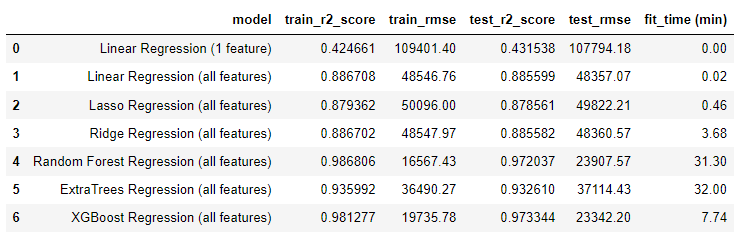
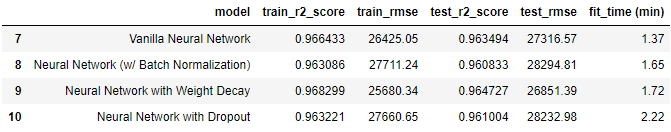

- Linear regression and Ridge regression performed closely with similar test RMSE
- On the other hand, Lasso regression performed worse compared to the above 2
- Overall, ensemble methods performed better
- Unique to pricing related data, I realize that for tree based models, you would not want to train your trees which are too deep as it will overfit on the training data
- We also note that the runtime for training XG Boost is much faster compared to Random Forest regression
- For tree-based models, note that the more number of trees within the model, the longer the runtime
- When there is too many trees to be run, there is a risk of memory error. Personally, the threshold for my computer was when I was trying to run 400 trees on gridsearch
- Surprisingly, Neural Networks were trained much faster than Random Forest and XGBoost
- Using RMSE as our guiding metric, XG Boost regression is the best model with the lowest test RMSE score

Why might XG Boost perform the best?

- It is a form of gradient boosting whereby the objective is to minimize the loss function of the model by adding weak learners using gradient descent. Gradient descent is an iterative optimization algorithm for finding a local minimum of differentiable function. As weak learners train on the remaining residual errors of a strong learner, it gives more importance and concentration to observations with high errors.

# Summary

<b>HDB Resale Price Index beginning from 1990 until present day</b>

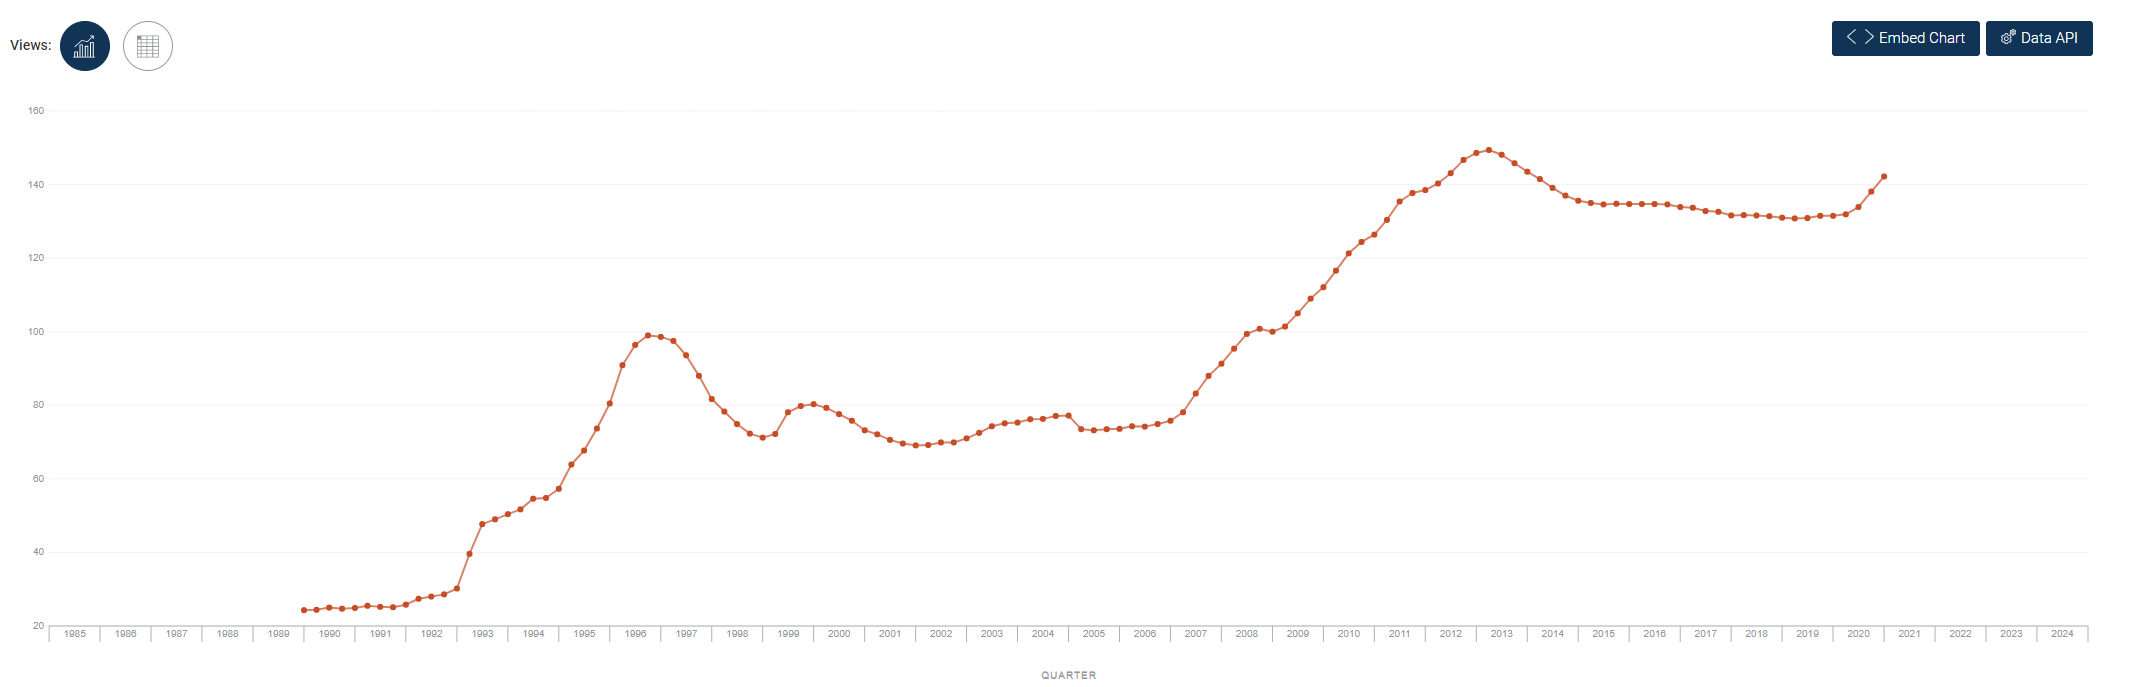

From data.gov.sg

- Singapore's HDB resale market generally goes through several property cycles. Although not collected within the dataset for this project, a quick Google search would show that HDB resale saw a price boom in the 90s as Singapore's economy was developing rapidly. It ended in the late 90s when the Asian Financial Crisis happened. The 2000s saw some price stagnation in the first half of the decade and quickly accelerated in the second half
- The model's predictive capacity is subjected to macro factors and policy changes which sometimes can be unforeseen and cause sharp changes in price trend
- Most recently, the government just announced new policies to curb 'lottery effects' of well placed HDB BTO projects and and make public housing more equitable: Prime Location Public Housing (PLH) model 
- Going forward, these PLH projects will be subjected to more stringent measures at the point of resale.
    - for example: longer MOP period would likely mean that there would less speculation. BTO applicants would likely be people who are more serious about long term house ownership and not using HDB as a stepping stone to cash out and upgrade to private housing

## Next Steps



- Retrain model with a larger dataset (use more historical HDB resale transactions)
- As an expansion of the project, I can collect private residential condo transactions and test our models' predictive capability
- We will try to use Flask to deploy our model

# Save best model for deployment using Flask

In [109]:
# referenced from: https://blog.cambridgespark.com/deploying-a-machine-learning-model-to-the-web-725688b851c7

In [110]:
pickle.dump(xg, open('hdb_model.p', 'wb'))

# Save dummy variables to convert our user input during deployment

In [111]:
enc_df

,town_BEDOK,town_BISHAN,town_BUKIT BATOK,town_BUKIT MERAH,town_BUKIT PANJANG,town_BUKIT TIMAH,town_CENTRAL AREA,town_CHOA CHU KANG,town_CLEMENTI,town_GEYLANG,town_HOUGANG,town_JURONG EAST,town_JURONG WEST,town_KALLANG/WHAMPOA,town_MARINE PARADE,town_PASIR RIS,town_PUNGGOL,town_QUEENSTOWN,town_SEMBAWANG,town_SENGKANG,town_SERANGOON,town_TAMPINES,town_TOA PAYOH,town_WOODLANDS,town_YISHUN,flat_type_2 ROOM,flat_type_3 ROOM,flat_type_4 ROOM,flat_type_5 ROOM,flat_type_EXECUTIVE,flat_type_MULTI-GENERATION,flat_model_Adjoined flat,flat_model_Apartment,flat_model_DBSS,flat_model_Improved,flat_model_Improved-Maisonette,flat_model_Maisonette,flat_model_Model A,flat_model_Model A-Maisonette,flat_model_Model A2,flat_model_Multi Generation,flat_model_New Generation,flat_model_Premium Apartment,flat_model_Premium Apartment Loft,flat_model_Premium Maisonette,flat_model_Simplified,flat_model_Standard,flat_model_Type S1,flat_model_Type S2,month_1/1/2013,...,month_5/1/2012,month_5/1/2013,month_5/1/2014,month_5/1/2015,month_5/1/2016,month_5/1/2017,month_5/1/2018,month_5/1/2019,month_5/1/2020,month_5/1/2021,month_6/1/2012,month_6/1/2013,month_6/1/2014,month_6/1/2015,month_6/1/2016,month_6/1/2017,month_6/1/2018,month_6/1/2019,month_6/1/2020,month_6/1/2021,month_7/1/2012,month_7/1/2013,month_7/1/2014,month_7/1/2015,month_7/1/2016,month_7/1/2017,month_7/1/2018,month_7/1/2019,month_7/1/2020,month_7/1/2021,month_8/1/2012,month_8/1/2013,month_8/1/2014,month_8/1/2015,month_8/1/2016,month_8/1/2017,month_8/1/2018,month_8/1/2019,month_8/1/2020,month_8/1/2021,month_9/1/2012,month_9/1/2013,month_9/1/2014,month_9/1/2015,month_9/1/2016,month_9/1/2017,month_9/1/2018,month_9/1/2019,month_9/1/2020,month_9/1/2021
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [112]:
cat_dict = dict(zip(enc_df.columns, range(enc_df.shape[1])))

In [113]:
cat_dict

{'town_BEDOK': 0,
 'town_BISHAN': 1,
 'town_BUKIT BATOK': 2,
 'town_BUKIT MERAH': 3,
 'town_BUKIT PANJANG': 4,
 'town_BUKIT TIMAH': 5,
 'town_CENTRAL AREA': 6,
 'town_CHOA CHU KANG': 7,
 'town_CLEMENTI': 8,
 'town_GEYLANG': 9,
 'town_HOUGANG': 10,
 'town_JURONG EAST': 11,
 'town_JURONG WEST': 12,
 'town_KALLANG/WHAMPOA': 13,
 'town_MARINE PARADE': 14,
 'town_PASIR RIS': 15,
 'town_PUNGGOL': 16,
 'town_QUEENSTOWN': 17,
 'town_SEMBAWANG': 18,
 'town_SENGKANG': 19,
 'town_SERANGOON': 20,
 'town_TAMPINES': 21,
 'town_TOA PAYOH': 22,
 'town_WOODLANDS': 23,
 'town_YISHUN': 24,
 'flat_type_2 ROOM': 25,
 'flat_type_3 ROOM': 26,
 'flat_type_4 ROOM': 27,
 'flat_type_5 ROOM': 28,
 'flat_type_EXECUTIVE': 29,
 'flat_type_MULTI-GENERATION': 30,
 'flat_model_Adjoined flat': 31,
 'flat_model_Apartment': 32,
 'flat_model_DBSS': 33,
 'flat_model_Improved': 34,
 'flat_model_Improved-Maisonette': 35,
 'flat_model_Maisonette': 36,
 'flat_model_Model A': 37,
 'flat_model_Model A-Maisonette': 38,
 'flat_mode

In [114]:
pickle.dump(cat_dict, open('cat_dict.p', 'wb'))

In [115]:
np.zeros(len(cat_dict))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])